# Best model from Heart of Gold 
This model was achieved by stacking multiple models on top of each other. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Global Parameters**

In [2]:
seed = 1234
x_data_path = "/kaggle/input/homework2/x_train.npy"
y_data_path = "/kaggle/input/homework2/y_train.npy"

**Data Loading**

In [3]:
from sklearn.model_selection import train_test_split

x = np.load(x_data_path)
y = np.load(y_data_path)

# Separate the test data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

**Model sub-components**

The main model is contructed starting from smaller blocks, below the function defing the individual sub-blocks can be found

In [4]:
#sine positional encoding as described by the paper 'attention is all you need'. This fragment of code is taken from the keras documentation.
class SinePositionEncoding(keras.layers.Layer):

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config


In [5]:
#build a multi layer perceptron
def get_mlp(hidden_units, dr=0):

    def mlp(x):
        for units in hidden_units:
            x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
            x = keras.layers.Dropout(dr)(x)
        return x
    return mlp;

#add positional encodings to the given inputs
def get_embeddings(inputs, dim):
        pe = SinePositionEncoding()(inputs)
        return tf.keras.layers.Add()([inputs,pe])

#TRANSFORMER MAIN ARCHITECTURE
def transformer(input_shape, ffn, num_heads, key_dim, embed_dim=0, stack_size = 1,dr = 0):
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    current =  get_embeddings(inputs, embed_dim)
    for i in range(stack_size):
    
        x1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(current,current)

        x1 = tf.keras.layers.Dropout(dr)(x1)
        x1 = tf.keras.layers.Add()([inputs,x1])
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x1)

        x2 = ffn(x1)
        x2 = tf.keras.layers.Add()([x1,x2])
        current = x2
        current = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    
    
    model= tf.keras.Model(inputs=inputs, outputs=current)
    #model._name='transformer'
    return model

#utility function
def get_transformer(input_layer, ffn, num_heads, key_dim, embed_dim=0, stack_size = 1,dr = 0):
    return transformer(input_layer.shape[-2:], ffn, num_heads, key_dim, embed_dim=0, stack_size = 1,dr = 0)(input_layer)

In [6]:
#define a model with several cnn layers as given by the filters parameters
def cnn(input_shape, filters, pool_size):
    inputs = tf.keras.layers.Input(shape=input_shape)
    current = inputs
    for n_filter in filters:
        cnn = tf.keras.layers.Conv1D(n_filter, 3, padding='same', activation='relu')(current)
        current = tf.keras.layers.AveragePooling1D(pool_size=pool_size, strides=1,padding="same")(cnn)
       
    model = tf.keras.Model(inputs=inputs, outputs=current)
    model._name='cnn'
    return model

#utility function
def get_cnn(input_layer, filters=[128,64,16],pool_size=2):
    return cnn(input_layer.shape[-2:], filters, pool_size)(input_layer)

In [7]:
#skip connection layer
def skip(skip_shape, main_shape, dr):
    
    skip = tf.keras.layers.Input(shape=skip_shape)
    main = tf.keras.layers.Input(shape=main_shape)
    
    skp0 = tf.keras.layers.Dense(main_shape[-1], activation="tanh")(skip) #used to match the dimension of the two branch
    skp0 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skp0)
    cnn = tf.keras.layers.LayerNormalization(epsilon=1e-6)(main)
    
    out = tf.keras.layers.Add()([skp0,cnn])
    
    out = tf.keras.layers.Dropout(dr, seed=seed)(out)
    #out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    
    model = tf.keras.Model(inputs=[skip,main], outputs=out)

    return model
    
#utility function
def get_skip(skip_layer, main_layer, dr):
    return skip(skip_layer.shape[-2:], main_layer.shape[-2:],dr)([skip_layer, main_layer])

In [8]:
#Simple classifier head
def classifier(input_shape, dr1, dr2):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    clf = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    
    clf = tf.keras.layers.Dropout(dr1)(clf)
    
    
    clf = tf.keras.layers.Dense(124, activation='relu')(clf)
    clf = tf.keras.layers.Dropout(dr2)(clf)

    outputs = tf.keras.layers.Dense(12, activation="softmax")(clf)
    
    model =  tf.keras.Model(inputs=inputs, outputs=outputs)
    model._name = 'classifier'
    return model

#utility function
def get_classifier(input_layer, dr1, dr2):
    return classifier(input_layer.shape[-2:], dr1, dr2)(input_layer)

In [9]:
#build a model with LSTM layers, the stack depht is defined by the stack_size parameter
def rnn(input_shape, dim, stack_size=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    current = inputs
    for i in range(stack_size):
         current = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim, dropout = 0.2,return_sequences=True))(current)
    
    model =  tf.keras.Model(inputs=inputs, outputs=current)
    #model._name='rnn'
    return model

#utility
def get_rnn(inputs_layer, dim ,stack_size=1):
    return rnn(inputs_layer.shape[-2:], dim, stack_size=1 )(inputs_layer)

# MAIN MODEL

The function below build the main model

In [10]:
def build_model(lstm_dim, embed_dim, key_dim, num_heads, dr_mid, dr_skip, cnn_filters, rnn_stack, atn_stack):

    inputs = tf.keras.layers.Input(shape=(36,6), name='Input')

    #CNN
    cnn = get_cnn(inputs, filters= cnn_filters)
    cnn = get_skip(inputs, cnn, dr_skip)

    #RNN
    rnn = get_rnn(cnn, lstm_dim, stack_size=rnn_stack)
    rnn = get_skip(cnn, rnn, dr_skip)
    rnn = get_skip(inputs, rnn, dr_skip)
    
    #ATTENTION 
    atn = get_transformer(rnn, get_mlp([embed_dim,rnn.shape[-1]]), num_heads, key_dim, stack_size= atn_stack, dr= dr_mid )
    atn = get_skip(rnn, atn, dr_skip)
    atn = get_skip(cnn, atn, dr_skip)
    atn = get_skip(inputs, atn, dr_skip)
    
    
    out = get_classifier(atn, dr_mid, dr_mid)
   
    model = tf.keras.Model(inputs=inputs, outputs=out)


    # Compile the model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Return the model
    return model

**Model parameters**

In [11]:
lstm_dim = 128 #dimensionality of the output space of the LSTM layers 
embed_dim = lstm_dim*2 #dimension of the first layer of the feed forward network of the transformer( after the self attention part)
key_dim = 64 #key, value and query dimension of the transformer

num_heads = 6  # Number of attention heads 

dr_mid = 0.5 #dropout of the ffn of the transformer
dr_skip = 0.5 #dropout in the skip layer

cnn_filters = [256,128,64,32,16] #filters size for the convolutional layers(each )

rnn_stack = 2 #depth of the LSTM stack
atn_stack = 2 #depth for the tranformer stack


In [12]:
model = build_model(lstm_dim, embed_dim, key_dim, num_heads, dr_mid, dr_skip, cnn_filters, rnn_stack,atn_stack)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

2022-12-22 17:09:19.273151: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


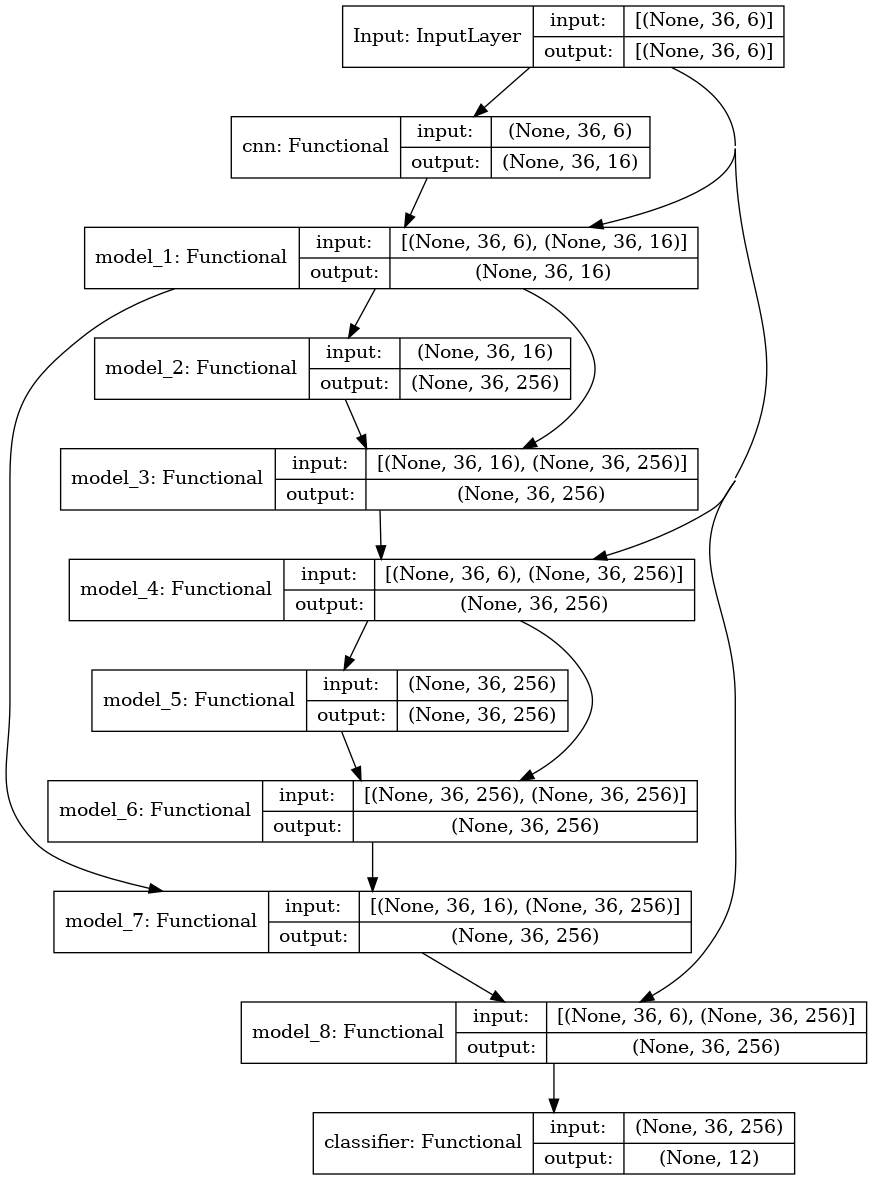

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True
)

In [ ]:
history = model.fit(x_train, y_train, batch_size=256, epochs=50, validation_data = (x_val, y_val), shuffle= True)